# Augmented Lagrangian

Consider the following optimization problem.

\begin{equation*}
\begin{aligned}
\min_{x,y} z = \sum_{i=1}^{n}(x_{i}c_{i} - c_{i})^2 + \sum_{i=1}^{n}(y_{i}d_{i} - d_{i})^2
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
s.t. && \sum_{i=1}^{n} x_ie_{1i} \geq  b_1 \\
&& \sum_{i=1}^{n} y_if_{2i} \geq  b_2 \\
&& \sum_{i=1}^{n} x_ie_{3i} + y_if_{3i} - 5b_3 = 0: && \lambda_{x} \\
&& \sum_{i=1}^{n} [x_ie_{4i} + y_if_{4i}] - 5b_4 = 0: && \lambda_{y}\\
&& x_i,y_i  \geq  0 && \forall i \in n
\end{aligned}
\end{equation*}

**Subproblem 1**

\begin{equation*}
\begin{aligned}
\min_{x,y} z = \sum_{i=1}^{n}(x_{i}c_{i} - c_{i})^2 + \bar{\lambda_{y}}(\sum_{i=1}^{n} [x_ie_{4i} + \bar{y_i}f_{4i}] - 5b_4) + \alpha (\sum_{i=1}^{n} [x_ie_{4i} + \bar{y_i}f_{4i}] - 5b_4)^2 + \\
\lambda_{x}(\sum_{i=1}^{n} [x_ie_{3i} + \bar{y_i}f_{3i}] - 5b_3) + \alpha(\sum_{i=1}^{n} [x_ie_{3i} + \bar{y_i}f_{3i}] - 5b_3)^2
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
s.t. && \sum_{i=1}^{n} x_ie_{1i} \geq  b_1 \\
&& x_i,\bar{y_i}  \geq  0 && \forall i \in n
\end{aligned}
\end{equation*}

**Subproblem 2**

\begin{equation*}
\begin{aligned}
\min_{x,y} z = \sum_{i=1}^{n}(y_{i}d_{i} - d_{i})^2 + \lambda_{y}(\sum_{i=1}^{n} [x_ie_{4i} + y_if_{4i}] - 5b_4) + \alpha (\sum_{i=1}^{n} [x_ie_{4i} + y_if_{4i}] - 5b_4)^2 + \\
\lambda_{x}(\sum_{i=1}^{n} [x_ie_{3i} + y_if_{3i}] - 5b_3) + \alpha(\sum_{i=1}^{n} [x_ie_{3i} + y_if_{3i}] - 5b_3)^2
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
s.t. && \sum_{i=1}^{n} y_if_{2i} \geq  b_2 \\
&& x_i,y_i  \geq  0 && \forall i \in n
\end{aligned}
\end{equation*}



## Initialization

\begin{equation*}
\begin{aligned}
{\lambda_x}^0, {\lambda_y}^0 = 2\\
{x_i}^{0}, {y_i}^{0} = 5 && \forall i \in n \\
\alpha = (1, 100, 0.01, 1.1^{v}, 0.9^{v})
\end{aligned}
\end{equation*}


In [34]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (10,10)

random.seed(10)

### Creating Variables

In [35]:
#number of x or y variables
num_var = 6

#number of constraints
num_cons = 4

#tolerance
epsilon = 3

e = []
f = []
b = []
c = []
d = []

#creating variables to store x and y variables and x and y lambda
x_vars_list = [[]]
y_vars_list = [[]]
lam1 = [2]
lam2 = [2]
obj_val = [0]
obj_val_x = []
obj_val_y = []

#creating random constraint coefficients and random b vector
for i in list(range(0,num_cons)):
    e.append([])
    f.append([])
    b.append(random.randrange(400,800,3))
    for j in list(range(0,num_var)):
        if i == 0:
            e[i].append(random.randrange(1,10,1))
            f[i].append(0)
        elif i == 1:
            e[i].append(0)
            f[i].append(random.randrange(1,10,1))
        else:
            e[i].append(random.randrange(1,10,1))
            f[i].append(random.randrange(1,10,1))

#low interconnection generator
#for i in  [-2,-1]:
#    for j in list(range(0,num_var)):
#        if i == -2:
#            e[i][j] = 30
#            f[i][j] = 0.001
#        if i == -1:
#            e[i][j] = 0.001
#            f[i][j] = 30

for i in list(range(0,num_var)):
        c.append(random.randrange(1,10,1))
        d.append(random.randrange(1,10,1))

for j in list(range(0,num_var)):
    #initializing variables (all x and y variables are 5)
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

### Solving X function

In [36]:
def solve_x(y_vars_list,lam1,lam2,obj_val_x):
    model = ConcreteModel()

    model.dual = Suffix(direction = Suffix.IMPORT)

    model.I = RangeSet(1,num_var)
    model.J = RangeSet(1,num_cons)

    model.x = Var(model.I, domain = NonNegativeReals)
    model.y = Var(model.I, domain = NonNegativeReals)
    
    #fixing the y values to the last row of stored y values
    for i in list(range(0,len(y_vars_list[0]))):
        model.y[i+1].value = y_vars_list[iteration-1][i]
        model.y[i+1].fixed = True

    #Defining Objective function
    def obj_rule(model):
        return sum((model.x[i]*c[i-1] - c[i-1])**2 for i in model.I) + \
            lam1[iteration-1]*(sum(model.x[i]*e[-2][i-1] + model.y[i]*f[-2][i-1] for i in model.I) - 5*b[-2]) + \
                                            alpha*(sum(model.x[i]*e[-2][i-1] + model.y[i]*f[-2][i-1] for i in model.I) - 5*b[-2])**2 +\
            lam2[iteration-1]*(sum(model.x[i]*e[-1][i-1] + model.y[i]*f[-1][i-1] for i in model.I) - 5*b[-1]) + \
                                            alpha*(sum(model.x[i]*e[-1][i-1] + model.y[i]*f[-1][i-1] for i in model.I) - 5*b[-1])**2                                
    
    model.obj = Objective(rule = obj_rule)

    #Defining constraints
    def cons_rule(model,j): 
        if  j == 1 :
            return sum(model.x[i] * e[j-1][i-1] + model.y[i] * f[j-1][i-1] for i in model.I) >= b[j-1]
        else: return Constraint.Skip

    model.cons = Constraint(model.J, rule = cons_rule)

    opt = SolverFactory('gurobi')
    result_obj = opt.solve(model)

    #model.pprint()

    x_vars_list.append([])
    for i in list(range(1,num_var+1)):
         x_vars_list[-1].append(value(model.x[i]))

    obj_val_x.append(value(model.obj))
    
    log_infeasible_constraints(model)

### Solving Y function

In [37]:
def solve_y(x_vars_list,lam1,lam2, obj_val_y):
    model = ConcreteModel()

    model.dual = Suffix(direction = Suffix.IMPORT)

    model.I = RangeSet(1,num_var)
    model.J = RangeSet(1,num_cons)

    model.x = Var(model.I, domain = NonNegativeReals)
    model.y = Var(model.I, domain = NonNegativeReals)

    #fixing x values
    for i in list(range(0,len(x_vars_list[0]))):
         model.x[i+1].value = x_vars_list[-1][i]
         model.x[i+1].fixed = True
    
    #Defining objective function
    def obj_rule(model):
        return sum((model.y[i]*d[i-1] - d[i-1])**2 for i in model.I) + \
            lam1[iteration-1]*(sum(model.x[i]*e[-2][i-1] + model.y[i]*f[-2][i-1] for i in model.I) - 5*b[-2]) + \
                                            alpha*(sum(model.x[i]*e[-2][i-1] + model.y[i]*f[-2][i-1] for i in model.I) - 5*b[-2])**2 +\
            lam2[iteration-1]*(sum(model.x[i]*e[-1][i-1] + model.y[i]*f[-1][i-1] for i in model.I) - 5*b[-1]) + \
                                            alpha*(sum(model.x[i]*e[-1][i-1] + model.y[i]*f[-1][i-1] for i in model.I) - 5*b[-1])**2                                
    model.obj = Objective(rule = obj_rule)

    #Defining constraints
    def cons_rule(model,j): 
        if  j == 2:
            return sum(model.x[i] * e[j-1][i-1] + model.y[i] * f[j-1][i-1] for i in model.I) >= b[j-1]
        else: return Constraint.Skip
    
    model.cons = Constraint(model.J, rule = cons_rule)
    
    opt = SolverFactory('gurobi')
    result_obj = opt.solve(model)

    #model.pprint()

    y_vars_list.append([])
    for i in list(range(1,num_var+1)):
        y_vars_list[-1].append(value(model.y[i]))
    
    obj_val_y.append(value(model.obj))
    
    log_infeasible_constraints(model)

## Setting $\alpha$ = 1

In [38]:
alpha = 1

#iterating through functions
convergence = False

while convergence == False:
 
    solve_x(y_vars_list,lam1,lam2, obj_val_x)
                    
    solve_y(x_vars_list,lam1,lam2, obj_val_y)

    #updating multipliers    
    lam1.append(lam1[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-2][i-1] +\
                                        y_vars_list[-1][i-1]*f[-2][i-1] for i in list(range(1,num_var+1))) - 5*b[-2])))
    lam2.append(lam2[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-1][i-1] +\
                                        y_vars_list[-1][i-1]*f[-1][i-1] for i in list(range(1,num_var+1))) - 5*b[-1])))
    iteration += 1
    obj_val.append(obj_val_x[-1] + obj_val_y[-1])

    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(lam1[-1],epsilon) == np.around(lam1[-2],epsilon) and \
                np.around(lam2[-1],epsilon) == np.around(lam2[-2],epsilon):
        convergence = True
    else: convergence = False

In [39]:
#Creating legend
x = []
y = []
for i in list(range(1,num_var+1)):
     x.append("x"+str(i)+"")
     y.append("y"+str(i)+"")

x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
lam1_dat = pd.DataFrame(lam1, columns = ['\u03BB1'])
lam2_dat = pd.DataFrame(lam2, columns = ['\u03BB2'])
obj_val_dat = pd.DataFrame(obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,lam1_dat,lam2_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λ1,λ2,Obj
0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000e+00,5.000000,2.000000,2.000000,0.000000e+00
1,61.151224,78.026312,65.659541,21.208942,57.975904,313.099199,36.173727,3.125514,2.212584e-12,61.372422,1.392174e-13,5.186964,120.035680,-55.625351,1.939903e+06
2,55.401001,70.246305,57.603681,20.448708,52.112638,271.599178,40.201384,8.083585,4.649982e-14,49.336132,2.397121e+00,38.628879,86.743740,-109.556182,1.508107e+06
3,53.977737,67.487267,51.859561,22.604400,49.828022,237.992883,47.416753,9.640661,1.396973e-10,69.772851,3.604070e+00,48.039123,64.759118,-150.285002,1.278031e+06
4,50.819903,63.226220,47.487196,22.154624,46.619586,215.523810,51.656963,10.723725,1.461849e+00,89.438469,4.943448e+00,55.217284,43.824410,-177.887034,1.120541e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,25.485616,31.164049,21.961895,12.575726,23.002177,94.701147,64.095759,15.670775,1.611875e+01,227.766860,1.550949e+01,93.634365,-178.799760,-230.032952,6.398593e+05
77,25.485547,31.163962,21.961828,12.575698,23.002113,94.700830,64.095779,15.670786,1.611879e+01,227.767245,1.550952e+01,93.634462,-178.800490,-230.032959,6.398591e+05
78,25.485488,31.163887,21.961770,12.575675,23.002058,94.700557,64.095797,15.670796,1.611883e+01,227.767576,1.550954e+01,93.634546,-178.801118,-230.032964,6.398589e+05
79,25.485437,31.163823,21.961720,12.575654,23.002011,94.700322,64.095812,15.670805,1.611886e+01,227.767861,1.550956e+01,93.634617,-178.801658,-230.032970,6.398588e+05


### Plotting X and Y

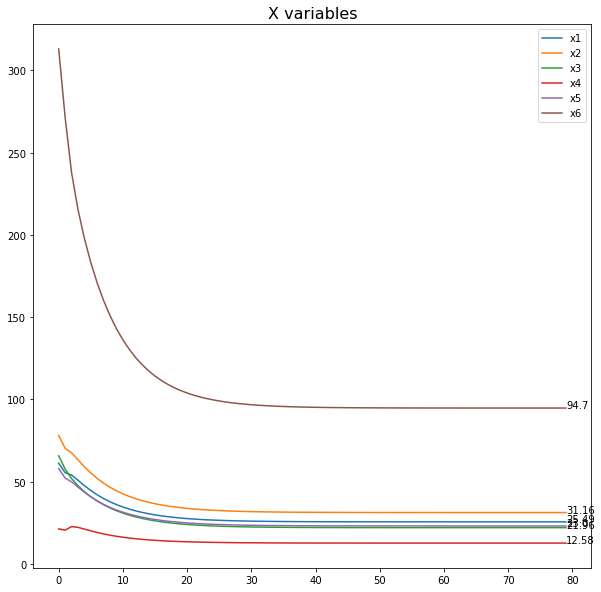

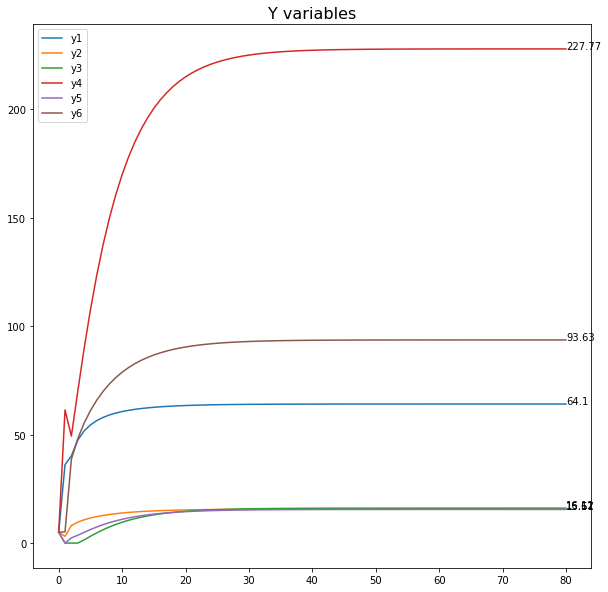

In [40]:
plt.plot(x_vars_list[1:][:], label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i-1,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
plt.show()

### Plotting $\lambda$ and objective function

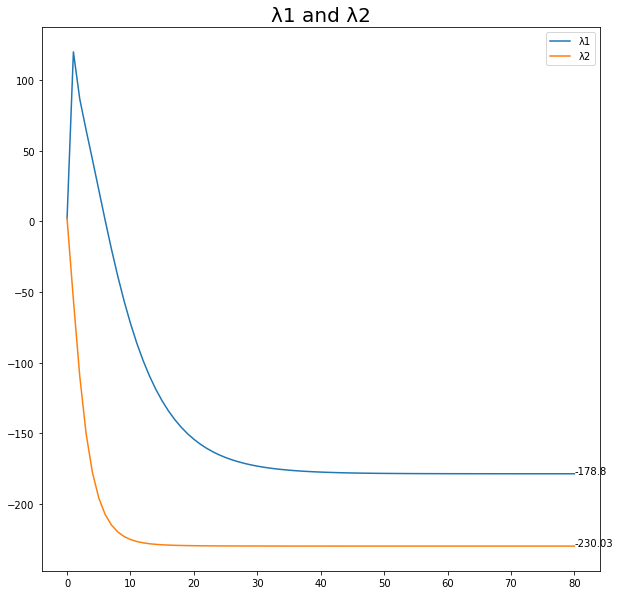

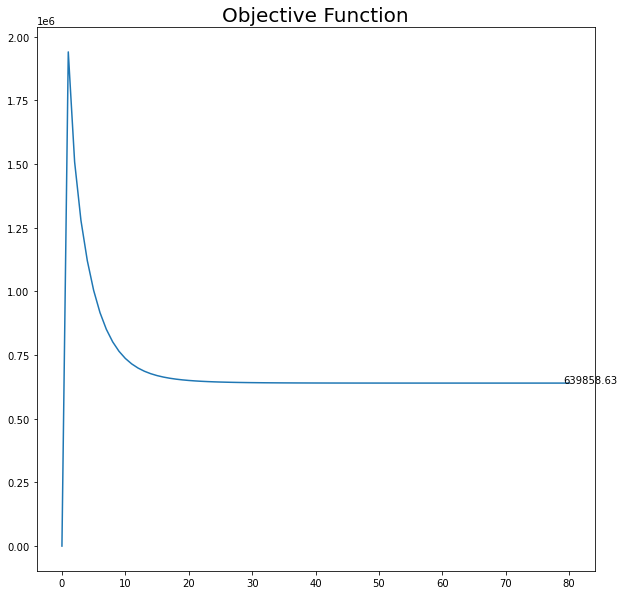

In [41]:
plt.plot(lam1, label = '\u03BB1'); #suppress matpolotlib output
plt.plot(lam2, label = '\u03BB2'); #suppress matpolotlib output

plt.text(iteration-1, lam1[-1], str(round(lam1[-1],2))); #suppress matpolotlib output
plt.text(iteration-1, lam2[-1], str(round(lam2[-1],2))); #suppress matpolotlib output

plt.legend(); #suppress matpolotlib output
plt.title('\u03BB1 and \u03BB2', fontsize = 20); #suppress matpolotlib output
plt.show()

plt.plot(obj_val);
plt.text(iteration-2,obj_val[-1],str(round(obj_val[-1],2)));
plt.title("Objective Function", fontsize = 20);
plt.show()

## Setting $\alpha$ = 100

In [42]:
alpha = 100

x_vars_list = [[]]
y_vars_list = [[]]
lam1 = [2]
lam2 = [2]
obj_val = [0]
obj_val_x = []
obj_val_y = []

for j in list(range(0,num_var)):
    #initializing variables (all x and y variables are 5)
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

#iterating through functions
convergence = False

while convergence == False and iteration <= 2000:

    solve_x(y_vars_list,lam1,lam2, obj_val_x)
                    
    solve_y(x_vars_list,lam1,lam2, obj_val_y)

    #updating multipliers    
    lam1.append(lam1[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-2][i-1] +\
                                        y_vars_list[-1][i-1]*f[-2][i-1] for i in list(range(1,num_var+1))) - 5*b[-2])))
    lam2.append(lam2[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-1][i-1] +\
                                        y_vars_list[-1][i-1]*f[-1][i-1] for i in list(range(1,num_var+1))) - 5*b[-1])))
    iteration += 1
    obj_val.append(obj_val_x[-1] + obj_val_y[-1])

    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(lam1[-1],epsilon) == np.around(lam1[-2],epsilon) and \
                np.around(lam2[-1],epsilon) == np.around(lam2[-2],epsilon):
        convergence = True
    else: convergence = False

In [43]:
x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
lam1_dat = pd.DataFrame(lam1, columns = ['\u03BB1'])
lam2_dat = pd.DataFrame(lam2, columns = ['\u03BB2'])
obj_val_dat = pd.DataFrame(obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,lam1_dat,lam2_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λ1,λ2,Obj
0,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000,5.000000e+00,5.000000e+00,5.000000,5.000000,5.000000e+00,5.000000e+00,2.000000,2.000000,0.000000e+00
1,51.583721,70.980519,78.801143,3.353192e+00,54.119278,409.220418,4.404555e-14,4.441994e-15,8.536833,67.021063,3.970606e-15,3.201305e-15,25078.594626,9873.543615,9.547797e+06
2,29.645208,47.484593,75.906259,1.357385e-13,37.936191,424.115577,7.653696e-01,4.052996e-13,7.209025,68.207781,2.673691e-02,6.936608e-14,12599.592369,4960.975491,-1.475351e+06
3,34.485710,52.564039,76.073909,9.747406e-12,41.402136,417.897980,1.952256e+00,1.747415e-11,6.768877,68.277918,2.343802e-10,2.677967e-12,6373.051438,2503.530689,1.231757e+06
4,37.217423,55.400702,76.033992,1.038143e-13,43.328228,413.552035,3.183863e+00,2.370401e-11,6.499514,68.119099,4.134461e-10,2.405996e-12,3261.711677,1271.999891,1.903977e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,27.170330,33.277997,23.577567,1.326381e+01,24.554554,102.227142,6.344711e+01,1.537707e+01,15.151419,218.925633,1.482452e+01,9.128059e+01,-165.367082,-229.113281,6.414617e+05
1997,27.167563,33.274526,23.574914,1.326268e+01,24.552005,102.214784,6.344818e+01,1.537756e+01,15.153007,218.940151,1.482565e+01,9.128446e+01,-165.389142,-229.114791,6.414565e+05
1998,27.164802,33.271061,23.572265,1.326155e+01,24.549460,102.202446,6.344924e+01,1.537804e+01,15.154593,218.954645,1.482677e+01,9.128832e+01,-165.411165,-229.116298,6.414513e+05
1999,27.162044,33.267601,23.569621,1.326042e+01,24.546919,102.190128,6.345030e+01,1.537852e+01,15.156176,218.969116,1.482789e+01,9.129217e+01,-165.433152,-229.117803,6.414462e+05


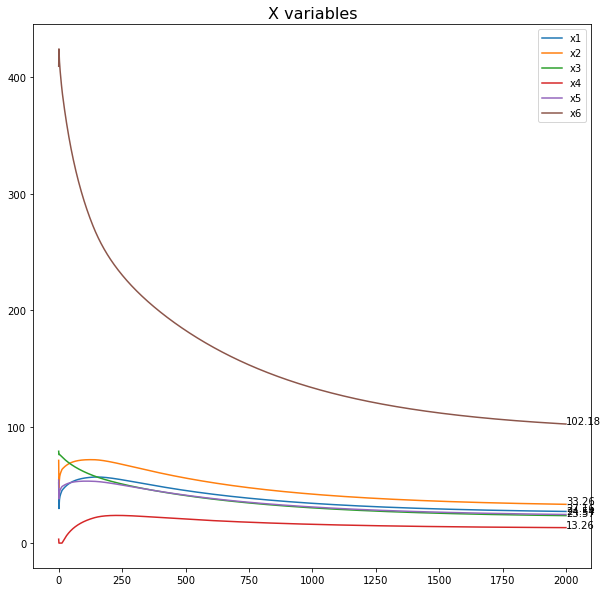

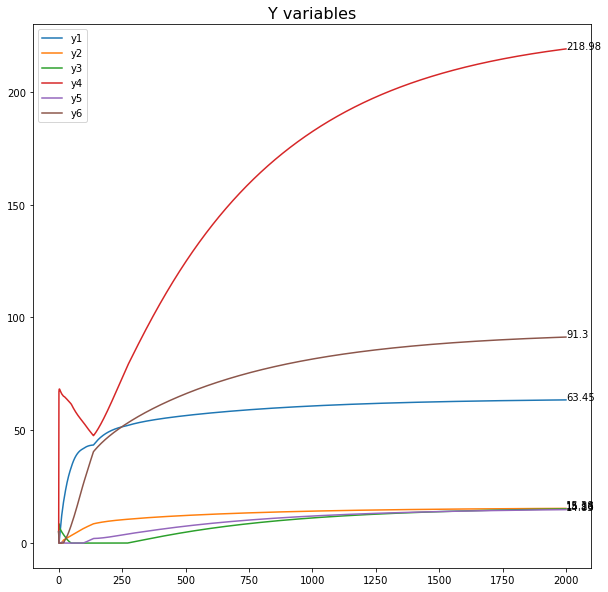

In [44]:
plt.plot(x_vars_list[1:][:], label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i-1,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
plt.show()

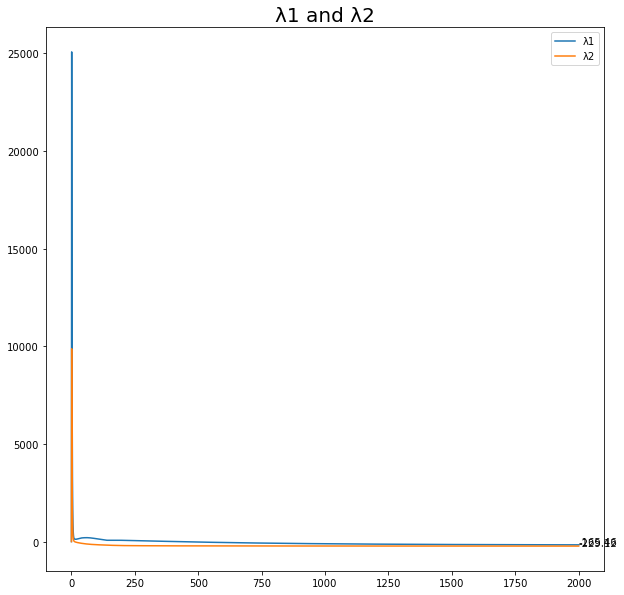

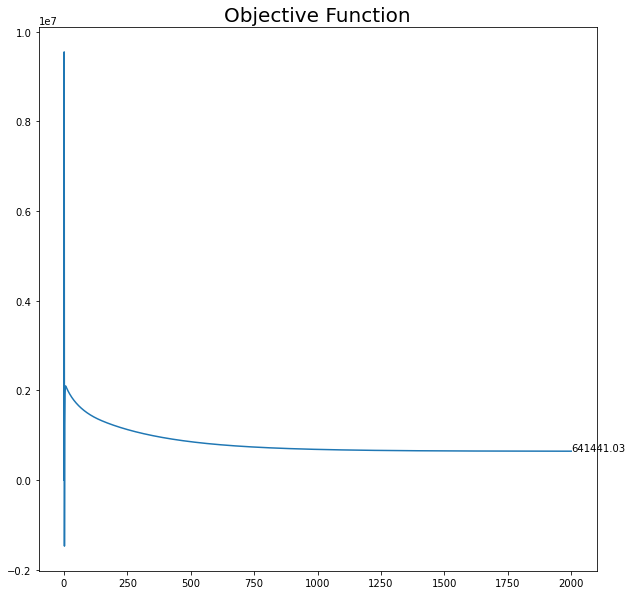

In [45]:
plt.plot(lam1, label = '\u03BB1'); #suppress matpolotlib output
plt.plot(lam2, label = '\u03BB2'); #suppress matpolotlib output

plt.text(iteration-1, lam1[-1], str(round(lam1[-1],2))); #suppress matpolotlib output
plt.text(iteration-1, lam2[-1], str(round(lam2[-1],2))); #suppress matpolotlib output

plt.legend(); #suppress matpolotlib output
plt.title('\u03BB1 and \u03BB2', fontsize = 20); #suppress matpolotlib output
plt.show()

plt.plot(obj_val);
plt.text(iteration-2,obj_val[-1],str(round(obj_val[-1],2)));
plt.title("Objective Function", fontsize = 20);
plt.show()

## Setting $\alpha$ = 0.01

In [46]:
alpha = 0.01

x_vars_list = [[]]
y_vars_list = [[]]
lam1 = [2]
lam2 = [2]
obj_val = [0]
obj_val_x = []
obj_val_y = []

for j in list(range(0,num_var)):
    #initializing variables (all x and y variables are 5)
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

#iterating through functions
convergence = False


while convergence == False:

    solve_x(y_vars_list,lam1,lam2, obj_val_x)
                  
    solve_y(x_vars_list,lam1,lam2, obj_val_y)

    #updating multipliers    
    lam1.append(lam1[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-2][i-1] +\
                                        y_vars_list[-1][i-1]*f[-2][i-1] for i in list(range(1,num_var+1))) - 5*b[-2])))
    lam2.append(lam2[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-1][i-1] +\
                                        y_vars_list[-1][i-1]*f[-1][i-1] for i in list(range(1,num_var+1))) - 5*b[-1])))
    iteration += 1
    obj_val.append(obj_val_x[-1] + obj_val_y[-1])

    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(lam1[-1],epsilon) == np.around(lam1[-2],epsilon) and \
                np.around(lam2[-1],epsilon) == np.around(lam2[-2],epsilon):
        convergence = True
    else: convergence = False

In [47]:
x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
lam1_dat = pd.DataFrame(lam1, columns = ['\u03BB1'])
lam2_dat = pd.DataFrame(lam2, columns = ['\u03BB2'])
obj_val_dat = pd.DataFrame(obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,lam1_dat,lam2_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λ1,λ2,Obj
0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,0.000000
1,7.801057,9.319608,6.399339,4.209974,7.193869,26.755694,14.894895,4.188678,4.927583,56.300009,4.429558,21.400487,-19.629612,-23.218342,278079.579202
2,9.178471,11.046221,7.871410,4.947735,8.320064,31.487732,20.037715,5.487619,5.908621,72.203119,5.606827,29.549084,-39.261641,-46.003746,450325.217501
3,11.172246,13.493735,9.539404,5.914589,10.102986,38.875700,24.889808,6.631502,7.160438,90.356649,6.781465,36.826645,-56.588183,-66.161818,591562.523658
4,12.879467,15.590379,10.971700,6.739963,11.630556,45.226933,29.190505,7.645052,8.268058,106.431640,7.821336,43.273829,-71.894653,-84.011848,688271.517590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,25.487121,31.165498,21.961361,12.577576,23.003124,94.695562,64.087827,15.669790,16.121733,227.777534,15.510887,93.631155,-178.848532,-229.994679,639859.699955
336,25.487087,31.165463,21.961361,12.577542,23.003101,94.695618,64.087963,15.669808,16.121688,227.777401,15.510867,93.631220,-178.847799,-229.995324,639859.667996
337,25.487054,31.165429,21.961362,12.577508,23.003077,94.695673,64.088097,15.669826,16.121644,227.777270,15.510847,93.631285,-178.847078,-229.995958,639859.636571
338,25.487022,31.165395,21.961363,12.577475,23.003055,94.695727,64.088228,15.669843,16.121600,227.777141,15.510828,93.631349,-178.846369,-229.996582,639859.605670


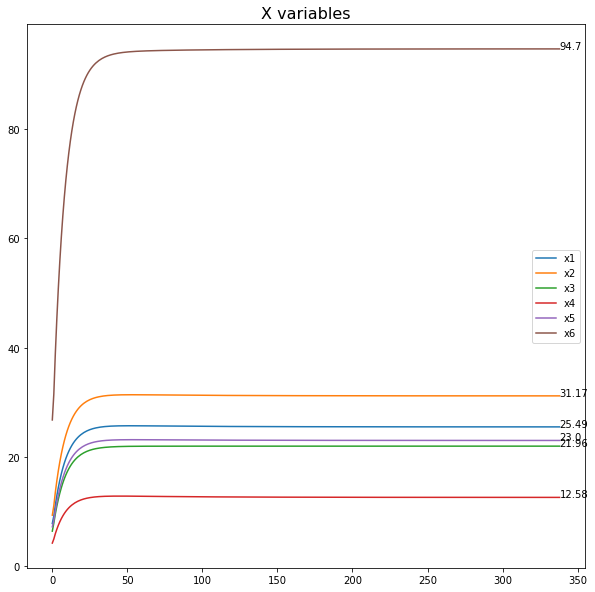

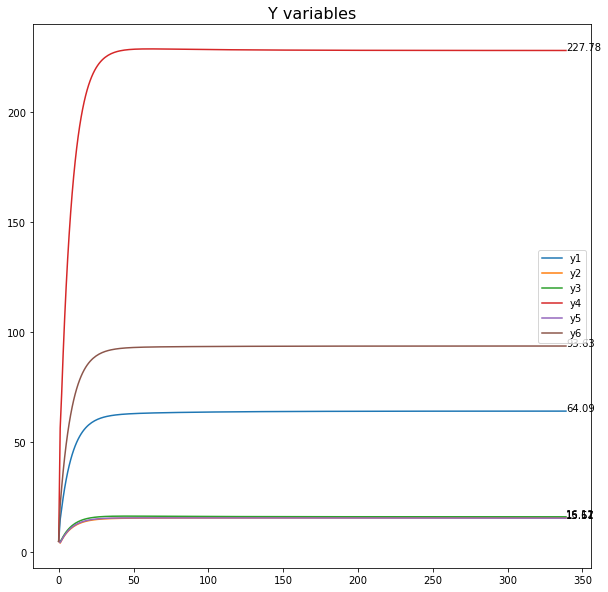

In [48]:
plt.plot(x_vars_list[1:][:], label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i-1,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
plt.show()

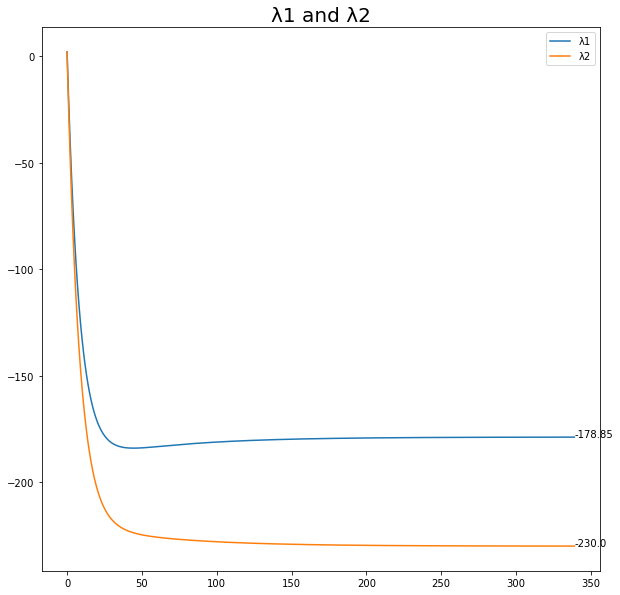

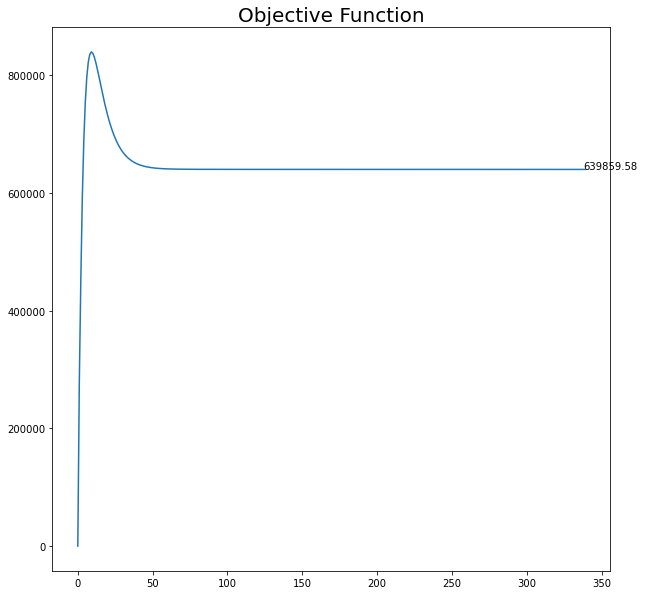

<Figure size 720x720 with 0 Axes>

In [49]:
plt.plot(lam1, label = '\u03BB1'); #suppress matpolotlib output
plt.plot(lam2, label = '\u03BB2'); #suppress matpolotlib output

plt.text(iteration-1, lam1[-1], str(round(lam1[-1],2))); #suppress matpolotlib output
plt.text(iteration-1, lam2[-1], str(round(lam2[-1],2))); #suppress matpolotlib output

plt.legend(); #suppress matpolotlib output
plt.title('\u03BB1 and \u03BB2', fontsize = 20); #suppress matpolotlib output
plt.show()
plt.savefig('AugLag_alpha_0.01_lams.png')

plt.plot(obj_val);
plt.text(iteration-2,obj_val[-1],str(round(obj_val[-1],2)));
plt.title("Objective Function", fontsize = 20);
plt.show()
plt.savefig('AugLag_alpha_0.01_obj.png')

## Dynamically increasing $\alpha$ by 10% per run

In [50]:
alpha = 1
epsilon = 4

x_vars_list = [[]]
y_vars_list = [[]]
lam1 = [2]
lam2 = [2]
obj_val = [0]
obj_val_x = []
obj_val_y = []

for j in list(range(0,num_var)):
    #initializing variables (all x and y variables are 5)
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

#iterating through functions
convergence = False


while convergence == False:
 
    solve_x(y_vars_list,lam1,lam2, obj_val_x)
                     
    solve_y(x_vars_list,lam1,lam2, obj_val_y)

    #updating multipliers    
    lam1.append(lam1[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-2][i-1] +\
                                        y_vars_list[-1][i-1]*f[-2][i-1] for i in list(range(1,num_var+1))) - 5*b[-2])))
    lam2.append(lam2[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-1][i-1] +\
                                        y_vars_list[-1][i-1]*f[-1][i-1] for i in list(range(1,num_var+1))) - 5*b[-1])))
    iteration += 1
    obj_val.append(obj_val_x[-1] + obj_val_y[-1])

    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(lam1[-1],epsilon) == np.around(lam1[-2],epsilon) and \
                np.around(lam2[-1],epsilon) == np.around(lam2[-2],epsilon):
        convergence = True
    else: convergence = False

    alpha = 1.1*alpha

In [51]:
x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
lam1_dat = pd.DataFrame(lam1, columns = ['\u03BB1'])
lam2_dat = pd.DataFrame(lam2, columns = ['\u03BB2'])
obj_val_dat = pd.DataFrame(obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,lam1_dat,lam2_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λ1,λ2,Obj
0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000e+00,5.000000,2.000000,2.000000,0.000000e+00
1,61.151224,78.026312,65.659541,21.208942,57.975904,313.099199,36.173727,3.125514,2.212584e-12,61.372422,1.392174e-13,5.186964,120.035680,-55.625351,1.939903e+06
2,55.593961,70.597975,58.281696,20.219416,52.399988,275.528498,40.044355,7.787159,8.150609e-11,49.923404,2.086345e+00,36.587238,92.767675,-108.223211,1.522069e+06
3,54.658344,68.504386,53.246253,22.423641,50.618272,245.600279,46.546003,9.387033,2.954711e-12,64.312150,3.211963e+00,46.258867,71.077042,-148.290261,1.306920e+06
4,52.577400,65.533144,49.630087,22.586544,48.340678,226.221108,50.363913,10.318898,5.600691e-01,80.044918,4.255456e+00,52.297109,53.034440,-175.059946,1.167277e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,34.171994,42.062372,30.286953,16.126805,31.005041,133.471939,60.759788,14.158024,1.113099e+01,182.193930,1.197828e+01,81.506880,-109.643221,-225.333765,6.811851e+05
125,34.171984,42.062359,30.286943,16.126800,31.005031,133.471892,60.759792,14.158025,1.113099e+01,182.193985,1.197828e+01,81.506894,-109.643300,-225.333756,6.811850e+05
126,34.171974,42.062347,30.286934,16.126796,31.005022,133.471849,60.759796,14.158027,1.113100e+01,182.194035,1.197829e+01,81.506908,-109.643377,-225.333754,6.811849e+05
127,34.171965,42.062336,30.286925,16.126793,31.005014,133.471811,60.759799,14.158029,1.113100e+01,182.194081,1.197829e+01,81.506920,-109.643451,-225.333755,6.811848e+05


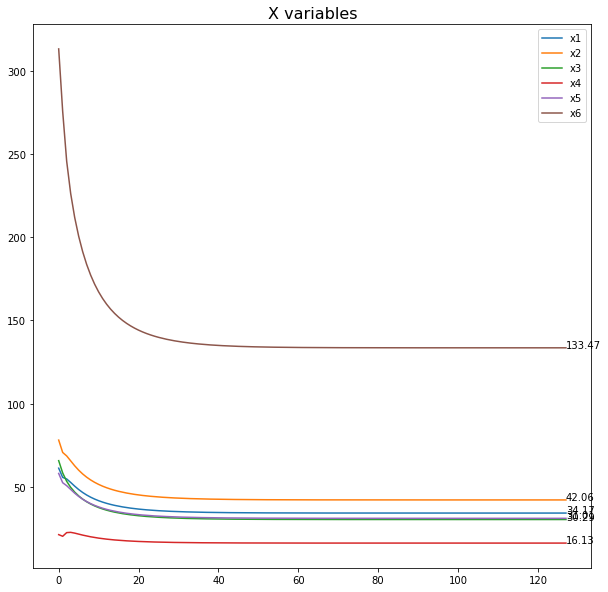

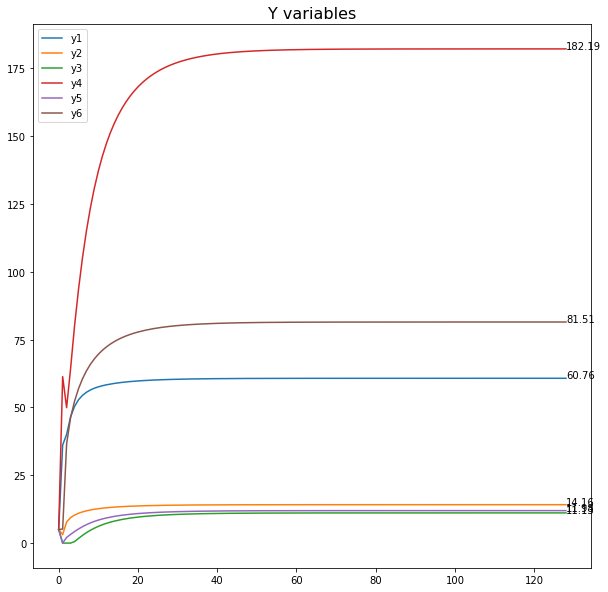

In [52]:
plt.plot(x_vars_list[1:][:], label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i-1,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
plt.show()

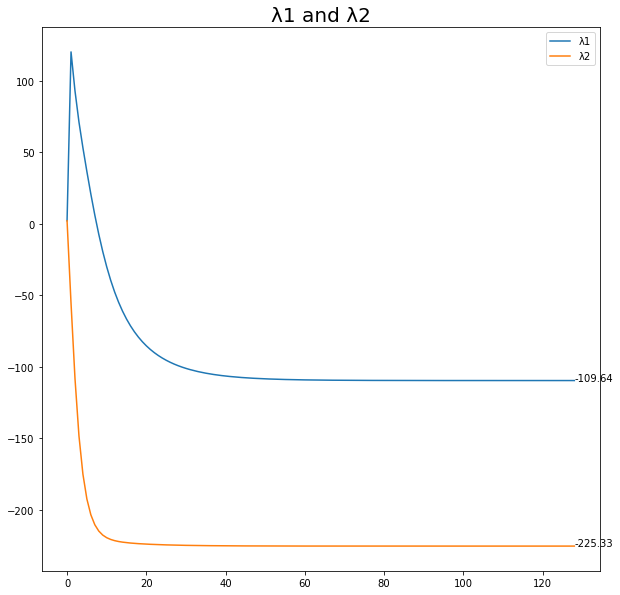

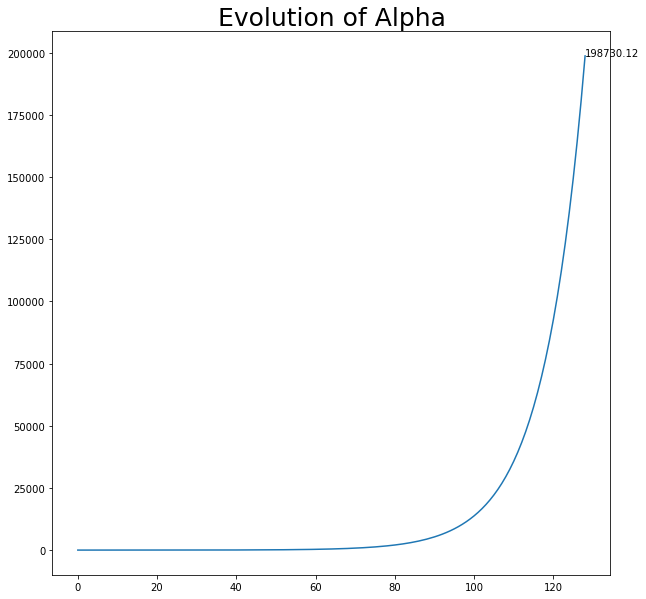

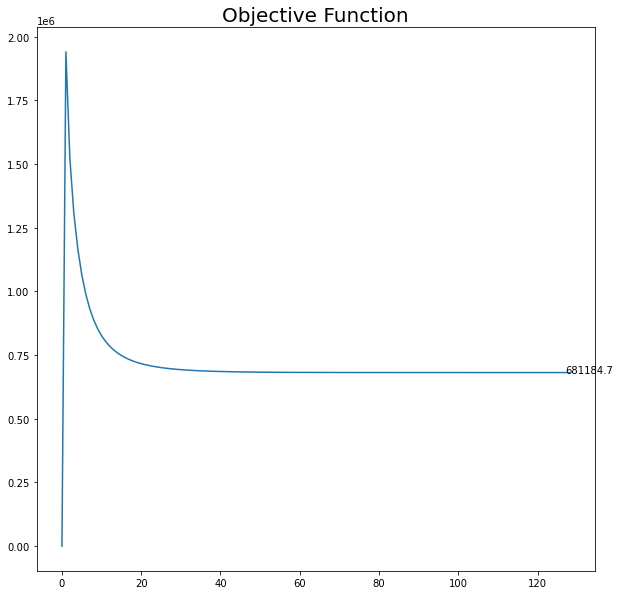

In [53]:
plt.plot(lam1, label = '\u03BB1'); #suppress matpolotlib output
plt.plot(lam2, label = '\u03BB2'); #suppress matpolotlib output
plt.text(iteration-1, lam1[-1], str(round(lam1[-1],2))); #suppress matpolotlib output
plt.text(iteration-1, lam2[-1], str(round(lam2[-1],2))); #suppress matpolotlib output
plt.legend(); #suppress matpolotlib output
plt.title('\u03BB1 and \u03BB2', fontsize = 20); #suppress matpolotlib output
plt.show()

alpha_plot = [1]
for i in list(range(0,iteration-1)):
    alpha_plot.append(1.1*alpha_plot[i])

plt.plot(alpha_plot)
plt.title('Evolution of Alpha', fontsize = 25)
plt.text(iteration-1, alpha_plot[-1], str(round(alpha_plot[-1],2)))
plt.show();

plt.plot(obj_val);
plt.text(iteration-2,obj_val[-1],str(round(obj_val[-1],2)));
plt.title("Objective Function", fontsize = 20);
plt.show()

## Dynamically decreasing $\alpha$ by 10% per run

In [54]:
alpha = 1
epsilon = 4

x_vars_list = [[]]
y_vars_list = [[]]
lam1 = [2]
lam2 = [2]
obj_val = [0]
obj_val_x = []
obj_val_y = []

for j in list(range(0,num_var)):
    #initializing variables (all x and y variables are 5)
    x_vars_list[0].append(5)
    y_vars_list[0].append(5)

iteration = 1

#iterating through functions
convergence = False


while convergence == False:

    solve_x(y_vars_list,lam1,lam2, obj_val_x)
                   
    solve_y(x_vars_list,lam1,lam2, obj_val_y)

    #updating multipliers    
    lam1.append(lam1[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-2][i-1] +\
                                        y_vars_list[-1][i-1]*f[-2][i-1] for i in list(range(1,num_var+1))) - 5*b[-2])))
    lam2.append(lam2[-1] + alpha*((sum(x_vars_list[-1][i-1]*e[-1][i-1] +\
                                        y_vars_list[-1][i-1]*f[-1][i-1] for i in list(range(1,num_var+1))) - 5*b[-1])))
    iteration += 1
    obj_val.append(obj_val_x[-1] + obj_val_y[-1])

    if all(np.around(x_vars_list[-1],epsilon) == np.around(x_vars_list[-2],epsilon)) and \
           all(np.around(y_vars_list[-1],epsilon) == np.around(y_vars_list[-2],epsilon)) and \
            np.around(lam1[-1],epsilon) == np.around(lam1[-2],epsilon) and \
                np.around(lam2[-1],epsilon) == np.around(lam2[-2],epsilon):
        convergence = True
    else: convergence = False

    alpha = .9*alpha

In [55]:
x_dat = pd.DataFrame(x_vars_list, columns=x)
y_dat = pd.DataFrame(y_vars_list, columns=y)
lam1_dat = pd.DataFrame(lam1, columns = ['\u03BB1'])
lam2_dat = pd.DataFrame(lam2, columns = ['\u03BB2'])
obj_val_dat = pd.DataFrame(obj_val, columns = ['Obj'])
pd.concat([x_dat,y_dat,lam1_dat,lam2_dat, obj_val_dat], axis= 1)

,x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6,λ1,λ2,Obj
0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000e+00,5.000000,2.000000,2.000000,0.000000e+00
1,61.151224,78.026312,65.659541,21.208942,57.975904,313.099199,36.173727,3.125514,2.212584e-12,61.372422,1.392174e-13,5.186964,120.035680,-55.625351,1.939903e+06
2,55.122645,69.779800,56.809203,20.664726,51.738919,267.073296,40.814203,8.229722,5.945477e-11,51.704772,2.551721e+00,39.564363,85.727737,-110.654818,1.491733e+06
3,52.710173,65.786542,50.148004,22.396656,48.549818,229.244541,48.437429,9.945902,5.243005e-01,76.535637,4.093473e+00,50.203803,60.054288,-152.351070,1.241124e+06
4,48.250227,59.949659,44.788028,21.251852,44.199583,202.583498,53.148324,11.215635,2.643974e+00,101.411604,5.830695e+00,58.830501,33.480516,-180.903854,1.065015e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,25.444699,31.121555,21.962467,12.534132,22.973321,94.766080,64.259191,15.692423,1.606499e+01,227.609188,1.548575e+01,93.713916,-177.939108,-230.794453,6.398194e+05
93,25.444703,31.121559,21.962467,12.534136,22.973324,94.766074,64.259175,15.692421,1.606499e+01,227.609203,1.548575e+01,93.713909,-177.939201,-230.794371,6.398194e+05
94,25.444707,31.121562,21.962467,12.534139,22.973327,94.766068,64.259161,15.692419,1.606500e+01,227.609217,1.548575e+01,93.713902,-177.939285,-230.794297,6.398194e+05
95,25.444710,31.121565,21.962467,12.534142,22.973329,94.766063,64.259149,15.692417,1.606500e+01,227.609230,1.548575e+01,93.713896,-177.939360,-230.794231,6.398194e+05


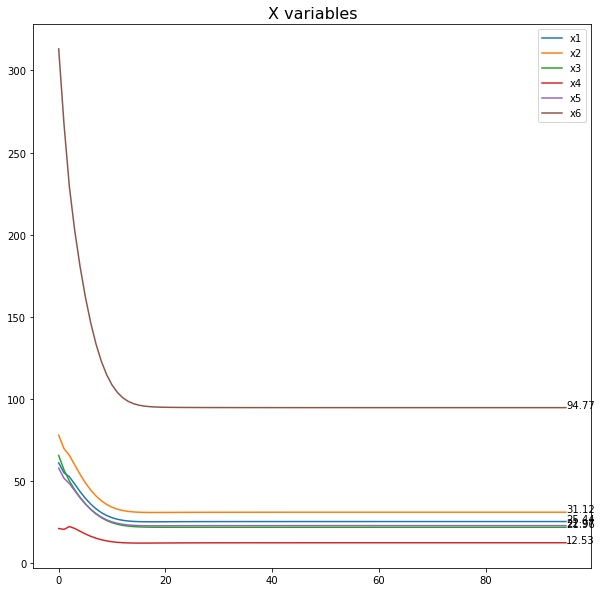

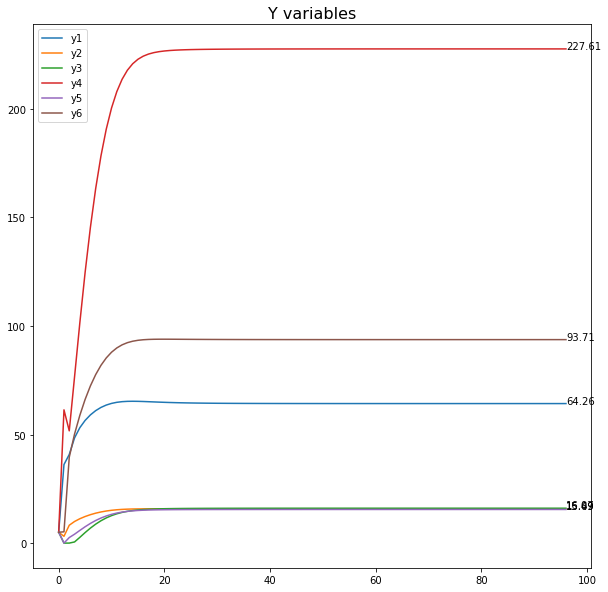

In [56]:
plt.plot(x_vars_list[1:][:], label = x);  # ; suppress the matplotlib text
plt.title("X variables",fontsize = 16)
if num_var <=20 :
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i-1,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(0,len(x_vars_list[0]))):
            plt.text(i,x_vars_list[i][j],str(round(x_vars_list[i][j],2)))
plt.show()

plt.plot(y_vars_list, label = y);  # ; suppress the matplotlib text
plt.title("Y variables",fontsize = 16)
if num_var <= 20:
    for i in [iteration-1]:
        for j in list(range(0,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
            plt.legend();
else:
    for i in [iteration-1]:
        for j in list(range(1,len(y_vars_list[0]))):
            plt.text(i,y_vars_list[i][j],str(round(y_vars_list[i][j],2)))
plt.show()

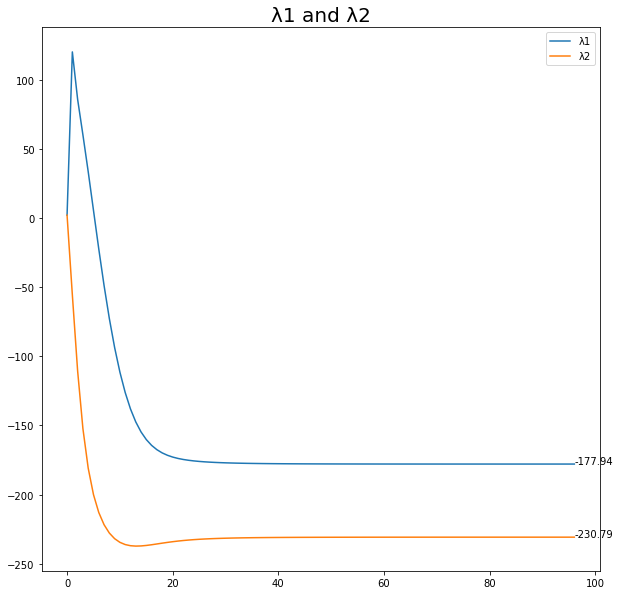

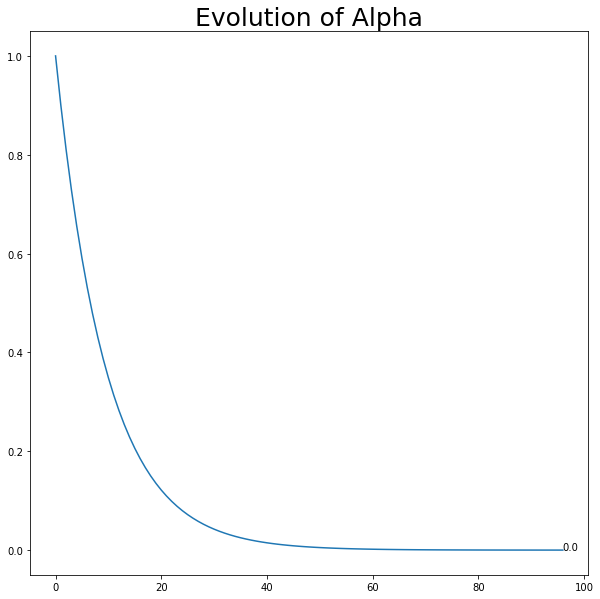

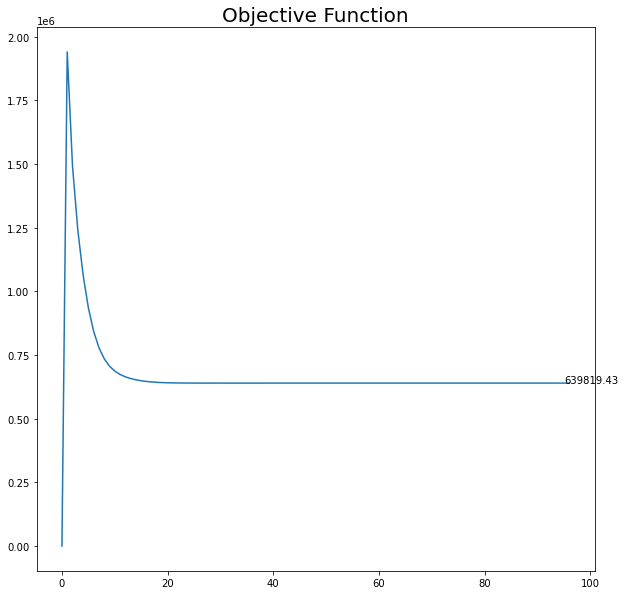

In [57]:
plt.plot(lam1, label = '\u03BB1'); #suppress matpolotlib output
plt.plot(lam2, label = '\u03BB2'); #suppress matpolotlib output
plt.text(iteration-1, lam1[-1], str(round(lam1[-1],2))); #suppress matpolotlib output
plt.text(iteration-1, lam2[-1], str(round(lam2[-1],2))); #suppress matpolotlib output
plt.legend(); #suppress matpolotlib output
plt.title('\u03BB1 and \u03BB2', fontsize = 20); #suppress matpolotlib output
plt.show()

alpha_plot = [1]
for i in list(range(0,iteration-1)):
    alpha_plot.append(0.9*alpha_plot[i])

plt.plot(alpha_plot)
plt.title('Evolution of Alpha', fontsize = 25)
plt.text(iteration-1, alpha_plot[-1], str(round(alpha_plot[-1],2)))
plt.show();


plt.plot(obj_val);
plt.text(iteration-2,obj_val[-1],str(round(obj_val[-1],2)));
plt.title("Objective Function", fontsize = 20);
plt.show()